In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader,TensorDataset


In [2]:
dataset = pd.read_csv("dataset/merged_data.csv")
dataset

,Breeding line,population,S1A_1158055,S1A_1238021,S1A_3452684,S1A_3469197,S1A_3793383,S1A_3978918,S1A_3978937,S1A_4159194,...,SUN_456673396,SUN_458088855,SUN_458680476,SUN_458680508,SUN_464606444,SUN_472782494,SUN_475092207,SUN_475092311,SUN_475287011,Yield
0,MASBC10038S_1001U,LND17_F5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,3.261735
1,MASBC10056S_3001,LND17_F5,0,0,0,0,0,0,0,0,...,1,0,2,2,0,1,0,2,2,3.706517
2,MASBC10056S_3003,LND17_F5,2,2,2,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,4.966733
3,MASBC10056S_3004U,LND17_F5,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,2,2,3.780648
4,MASBC10056S_3005,LND17_F5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,1,2.594562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,SWW14498DH840,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,9.118033
1764,SWW14498DH860,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,6.523471
1765,SWW14498DH870,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,7.042383
1766,SWW14498DH880,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,8.747381


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary())

cuda
NVIDIA GeForce RTX 4070 Laptop GPU
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool 

In [3]:
def get_SNP(path):   
    df = pd.read_csv(f"dataset/{path}")
    df = df.drop(["Breeding line", "population"],axis=1) # All SNP columns
    X = df.drop(["Yield"],axis=1)
    y = df['Yield']  # Convert phenotype to float
    
    X_var_filtered = np.array(X)
    y = np.array(y)

    # Train-Test split (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_var_filtered, y, test_size=0.2)

    # Further split train into train/val (80/20 split of the train set)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2)
    
    input_dim = X_train.shape[1]

    class SNPPhenotypeDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)  
            self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]
        
    train_dataset = SNPPhenotypeDataset(X_train, y_train)
    val_dataset   = SNPPhenotypeDataset(X_val, y_val)
    test_dataset  = SNPPhenotypeDataset(X_test, y_test)

    batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader,input_dim

In [4]:
def createANNModel(hidden_units, drop,lr,decay,input_length,activation_type="relu",optimizer_type="adam",batch=False):
    class ANN(nn.Module):
        def __init__(self, hidden_units, drop, activation_type,input_length):
            super(ANN, self).__init__()

            self.nLayers = len(hidden_units)
            
            self.activations = {
                'relu': F.relu,              
                'leaky_relu': F.leaky_relu,  
                'elu': F.elu,
                "tanh": F.tanh        
            }

            self.activation = self.activations.get(activation_type.lower(), F.relu)

            self.layers = nn.ModuleDict()

            self.batch_norms = nn.ModuleDict()

            self.layers["input"] = nn.Linear(input_length, hidden_units[0])
            self.batch_norms["input"] = nn.BatchNorm1d(hidden_units[0])

            for i in range(self.nLayers - 1):
                self.layers[f"hidden{i}"] = nn.Linear(hidden_units[i], hidden_units[i+1])
                self.batch_norms[f"hidden{i}"] = nn.BatchNorm1d(hidden_units[i+1])
            
            self.layers["output"] = nn.Linear(hidden_units[-1], 1)

            self.dropout = nn.Dropout(p=drop)
            
        def forward(self,x):

            x = self.layers['input'](x)
            if batch:
                x = self.batch_norms["input"](x)
            x = self.activation(x)

            # hidden layers
            for i in range(self.nLayers - 1):
                x = self.layers[f'hidden{i}'](x)
                if batch:
                    x = self.batch_norms[f'hidden{i}'](x)
                x = self.activation(x)
                x = self.dropout(x)

            # return output layer
            x = self.layers['output'](x)
            return x
    
    
    model = ANN(hidden_units,drop,activation_type,input_length)

    criterion = nn.MSELoss()

    optimizers = {
    'adam': lambda: torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay),
    'sgd': lambda: torch.optim.SGD(model.parameters(), lr=lr, weight_decay=decay, momentum=0.9),
    "adamw": lambda: torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=decay),
    "rmsprop": lambda: torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=decay, alpha=0.99,momentum=0.9),
    }
    optimizer = optimizers.get(optimizer_type.lower(), optimizers['adam'])()

    return model, criterion, optimizer

In [5]:
def trainAndEval(model,criterion,optimizer,max_epochs=300,patience=10):
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    model.to(device)
    patience = 15
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Training loop
    for epoch in range(max_epochs):
        model.train()
        running_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)  # Reshape y to match output

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)  # Reshape y to match output
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                running_val_loss += loss.item() * batch_X.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(epoch_val_loss)

        #print(f"Epoch [{epoch+1}/{max_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early Stopping Check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            #print(f"Early stopping triggered after {epoch+1} epochs")
            #print(f"Final Train loss: {train_losses[-1]:.4f} | Final Val Loss: {val_losses[-1]:.4f}")
            break

    # Load best model for evaluation
    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    return model,train_losses,val_losses

In [6]:
def performance_metrics(model,test_loader):
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(batch_y.numpy().reshape(-1, 1))  # Reshape to match predictions

    y_pred = np.concatenate(all_preds).reshape(-1)
    y_true = np.concatenate(all_targets).reshape(-1)

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return y_pred,y_true,mse,mae,r2

In [7]:
def counter_performance(repeat,dataset="dataset/merged_data.csv"):
    repeat = f"repeat{repeat}"
    dataset_name = dataset.split("/")[-1:][0]
    df = pd.read_csv(dataset)

    model_stats = {
        "repeat": repeat,
        "dataset": [dataset_name],
        "dataset size" : df.shape[1],
        "MSE": [round(mse,3)],
        "MAE": [round(mae,3)],
        "R2": [round(r2,3)]
    }

    model_stats_df = pd.DataFrame(model_stats)
    model_stats_df.to_csv(f"raw_mlp/{dataset_name}_{repeat}.csv", index=False)


=== Final Evaluation on Test Set ===
MSE:  2.5072
MAE:  1.2399
R^2:  0.6773


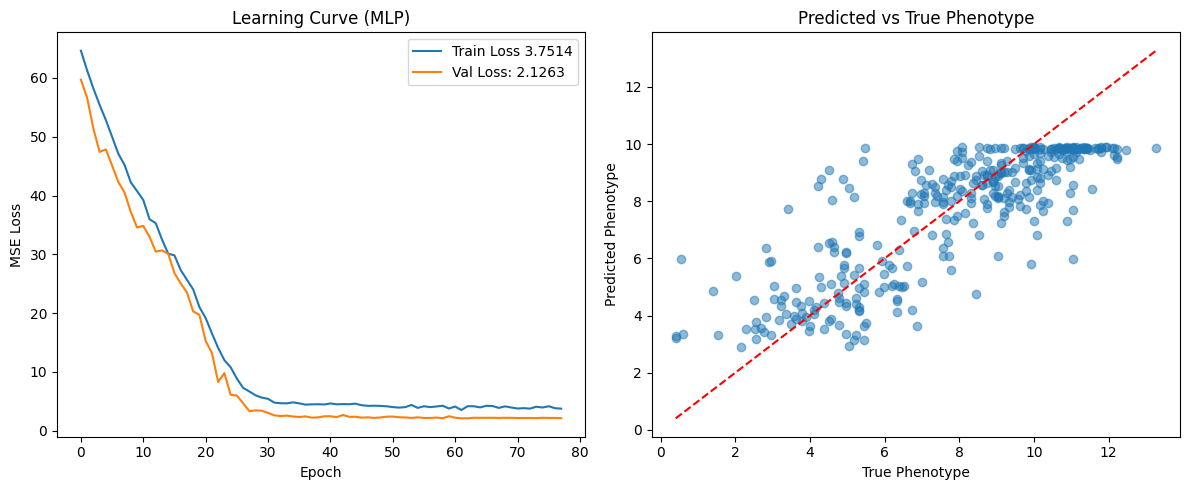


=== Final Evaluation on Test Set ===
MSE:  2.6076
MAE:  1.2334
R^2:  0.6512


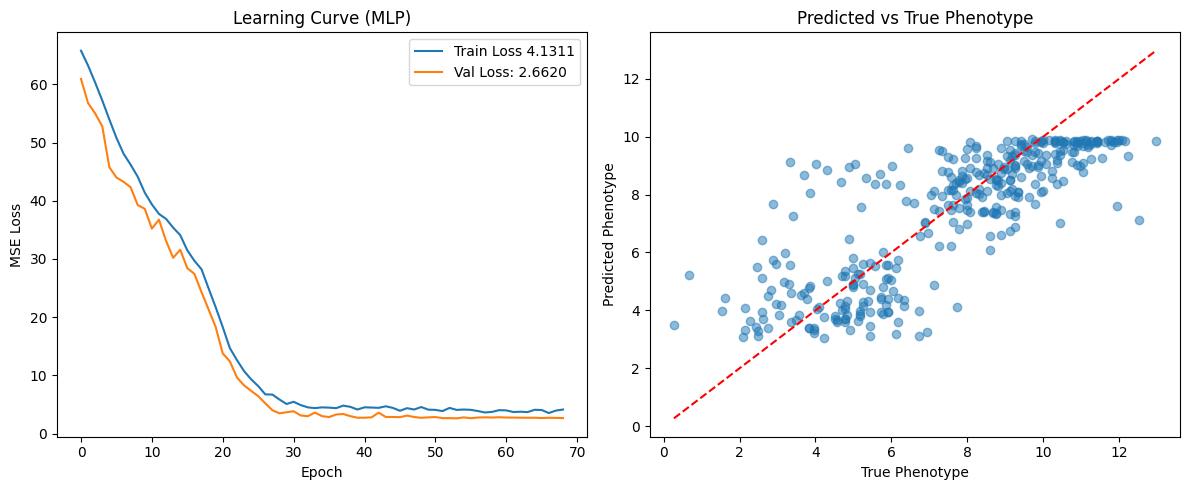


=== Final Evaluation on Test Set ===
MSE:  2.3173
MAE:  1.1643
R^2:  0.6774


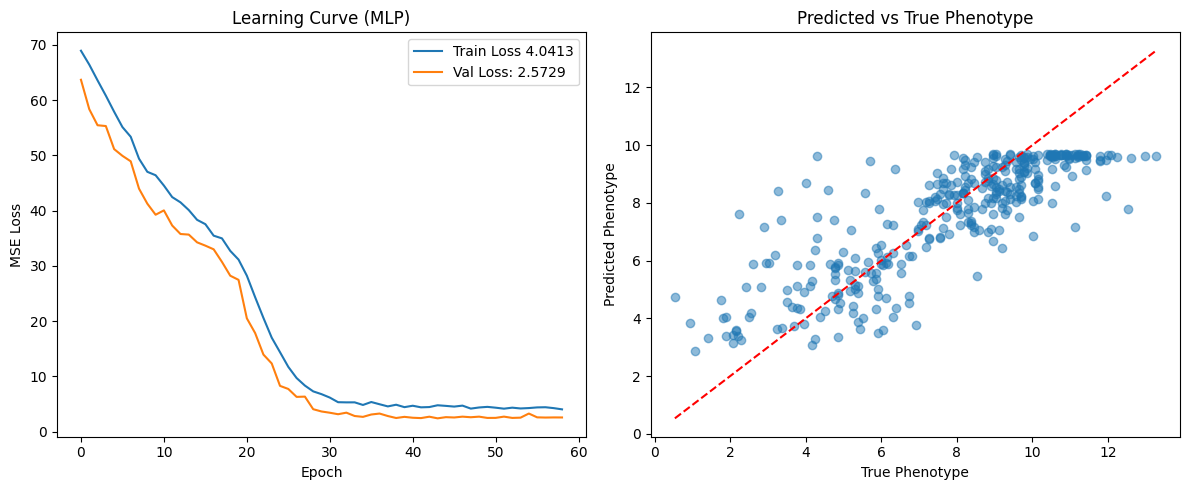


=== Final Evaluation on Test Set ===
MSE:  2.2828
MAE:  1.1684
R^2:  0.6748


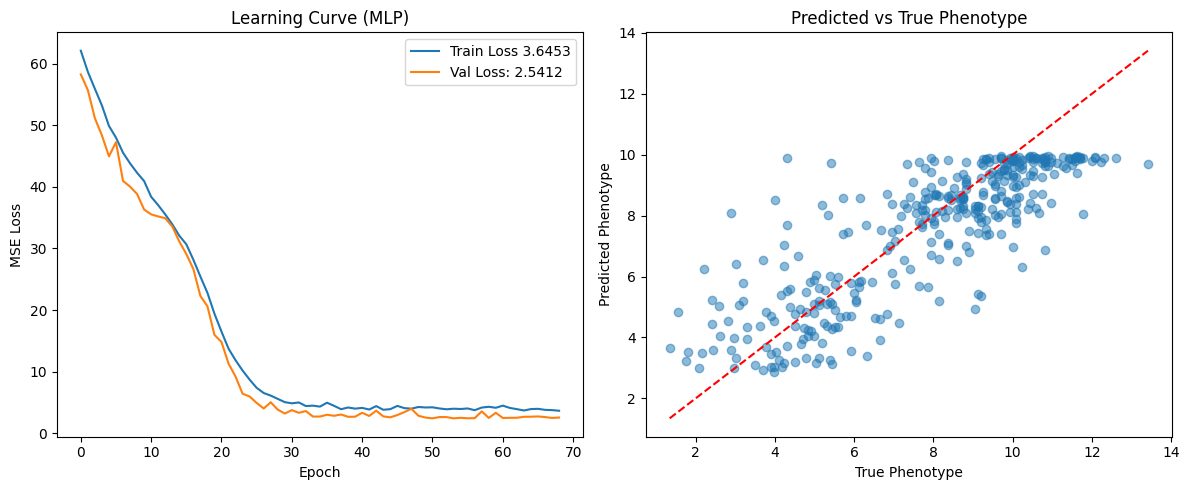


=== Final Evaluation on Test Set ===
MSE:  2.5821
MAE:  1.2608
R^2:  0.6445


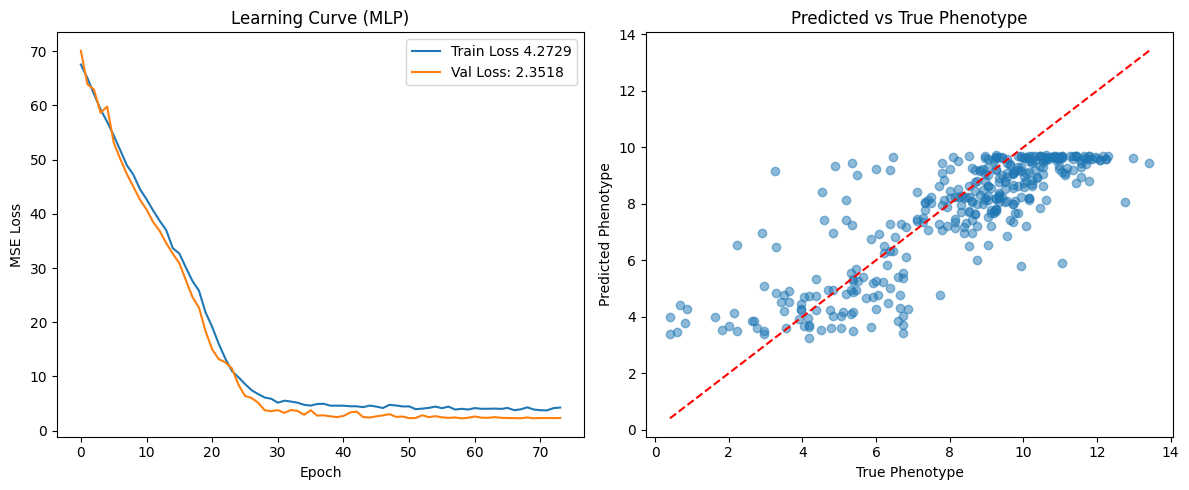

In [9]:
for repeat in range(5):   
    train_loader, val_loader, test_loader,input_dim = get_SNP("merged_data.csv")
    model, criterion, optimizer =createANNModel(hidden_units=[16,16,16,8],drop=0.3,lr=1e-3,decay=1e-5,input_length=input_dim,activation_type="tanh",optimizer_type="adam",batch=True)
    trained_model,train_losses,val_losses = trainAndEval(model,criterion,optimizer,max_epochs=150,patience=50)
    y_pred,y_true,mse,mae,r2 = performance_metrics(trained_model,test_loader)
    counter_performance(repeat=repeat)
    PATH = f"MLP_models/best_MLP_for_previous{repeat}_wo_batch.pth"
    torch.save(trained_model.state_dict(), PATH)

    print("\n=== Final Evaluation on Test Set ===")
    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R^2:  {r2:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss {train_losses[-1]:.4f}')
    plt.plot(val_losses, label=f'Val Loss: {val_losses[-1]:.4f}')
    plt.title("Learning Curve (MLP)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title("Predicted vs True Phenotype")
    plt.xlabel("True Phenotype")
    plt.ylabel("Predicted Phenotype")

    plt.tight_layout()
    plt.show()

folder_path = "raw_mlp"  
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

df_list = []
for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv("Results/combined_output_previous_study_wo_batch.csv", index=False)


In [ ]:
def importance_graph(model, datapath, snp_number=20):
    N = snp_number
    weight_keys = [k for k in model.state_dict().keys() if 'weight' in k]
    input_weights = model.state_dict()[weight_keys[0]]
    importance_scores = input_weights.mean(dim=0).cpu().numpy()
    df = pd.read_csv(datapath)    
    X = df.drop(["Breeding line","population","Yield"],axis=1)
    snp_names = np.array(X.columns)
    sorted_indices = np.argsort(importance_scores)
    
    n_positive = N // 2
    n_negative = N - n_positive
    top_positive_indices = sorted_indices[-n_positive:]
    top_negative_indices = sorted_indices[:n_negative]
    
    fig_height = max(5, min(N * 0.4, 20))
    plt.figure(figsize=(10, fig_height))
    plt.barh(snp_names[top_positive_indices], importance_scores[top_positive_indices], color="forestgreen", label="Positive Effect")
    plt.barh(snp_names[top_negative_indices], importance_scores[top_negative_indices], color="firebrick", label="Negative Effect")
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel("Feature Importance (Weight Value)")
    plt.ylabel("SNPs")
    plt.title(f"Top {N} SNPs Affecting Phenotype")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"important_{snp_number}_snps.png", dpi=300)
    plt.show()
    
    all_top_indices = np.concatenate([top_negative_indices, top_positive_indices])
    return all_top_indices, importance_scores[all_top_indices]

ANN(
  (layers): ModuleDict(
    (input): Linear(in_features=11089, out_features=16, bias=True)
    (hidden0): Linear(in_features=16, out_features=16, bias=True)
    (hidden1): Linear(in_features=16, out_features=16, bias=True)
    (hidden2): Linear(in_features=16, out_features=8, bias=True)
    (output): Linear(in_features=8, out_features=1, bias=True)
  )
  (batch_norms): ModuleDict(
    (input): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)

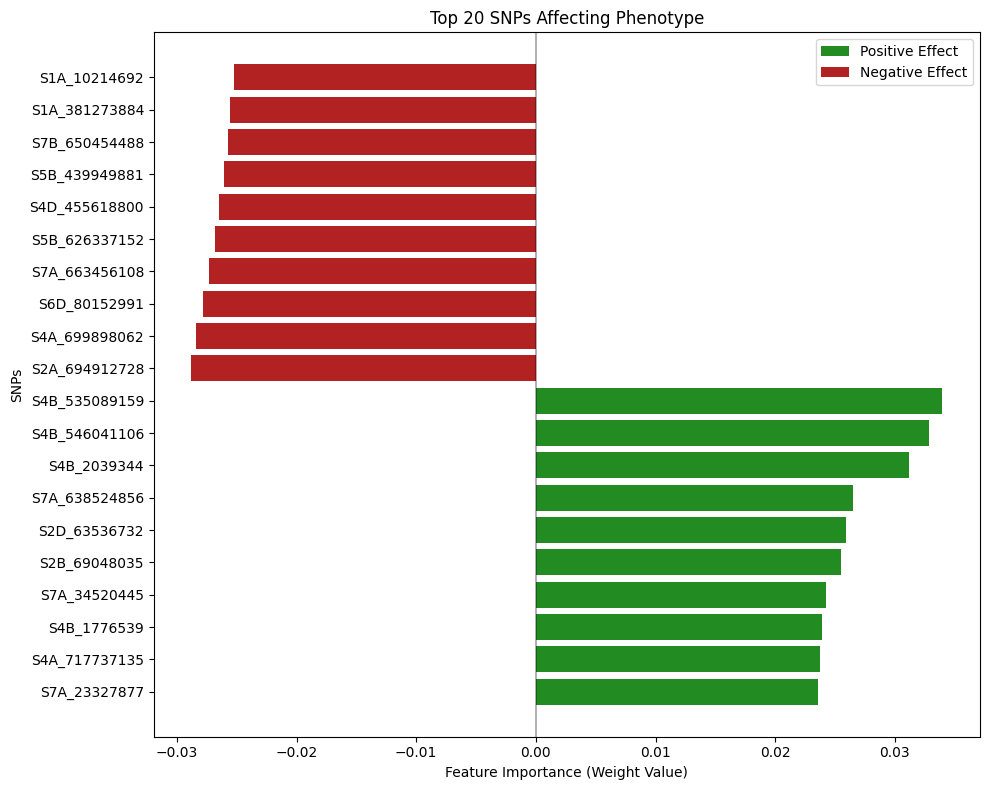

In [21]:
PATH = "MLP_models/best_MLP_for_previous1.pth"
input_dim = get_SNP("merged_data.csv")[-1]
model = createANNModel(hidden_units=[16,16,16,8],drop=0.3,lr=1e-3,decay=1e-5,input_length=input_dim,activation_type="tanh",optimizer_type="adam",batch=True)[0]
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()
top_snp_indices, top_snp_scores = importance_graph(model, datapath="dataset/merged_data.csv", snp_number=20)

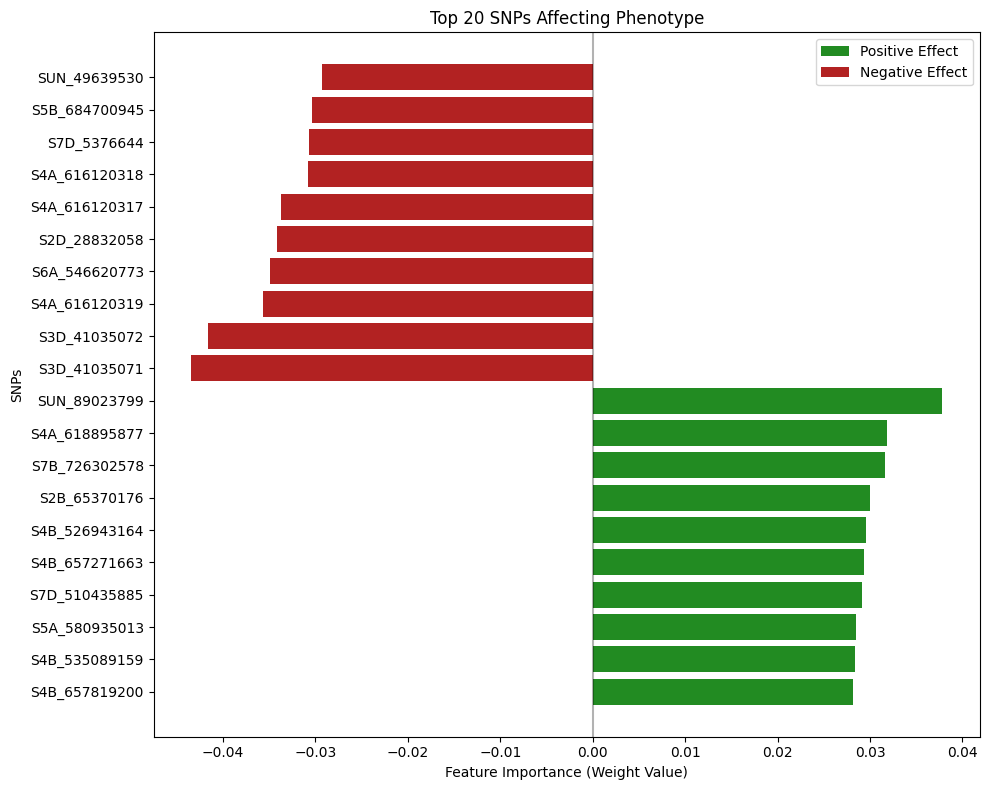

In [ ]:
PATH = "MLP_models/best_MLP_for_previous2.pth"
input_dim = get_SNP("merged_data.csv")[-1]
model = createANNModel(hidden_units=[16,16,16,8],drop=0.3,lr=1e-3,decay=1e-5,input_length=input_dim,activation_type="tanh",optimizer_type="adam",batch=True)[0]
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()
top_snp_indices, top_snp_scores = importance_graph(model, datapath="dataset/merged_data.csv", snp_number=20)

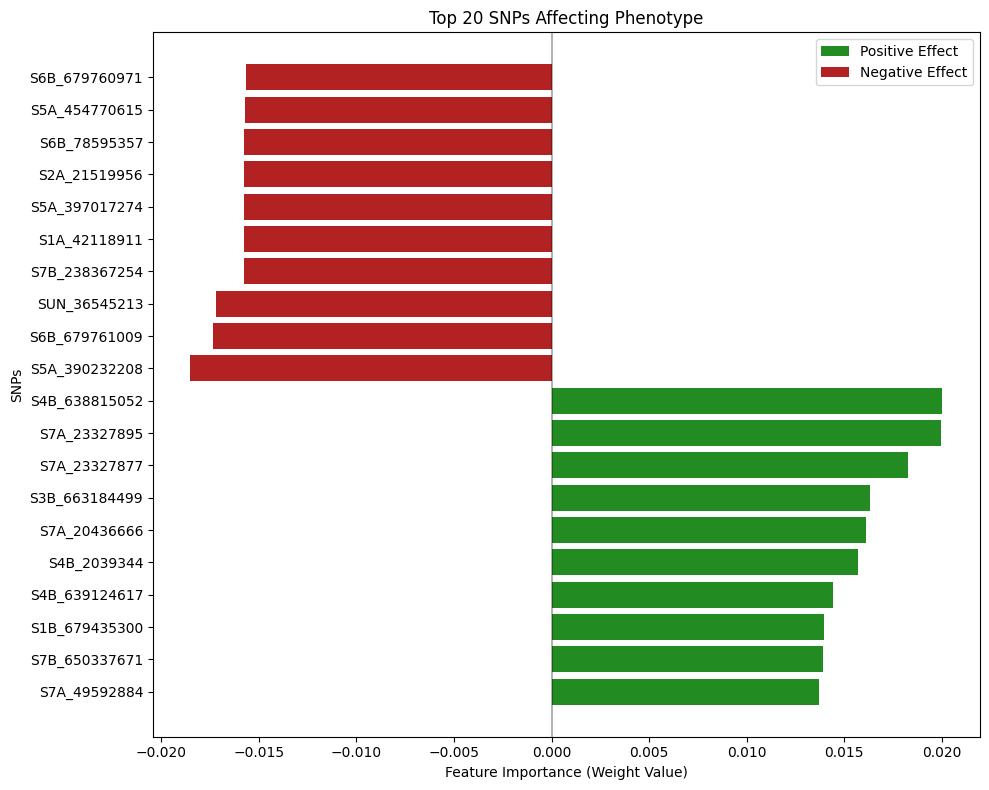

In [23]:
PATH = "MLP_models/best_MLP_for_previous3.pth"
input_dim = get_SNP("merged_data.csv")[-1]
model = createANNModel(hidden_units=[16,16,16,8],drop=0.3,lr=1e-3,decay=1e-5,input_length=input_dim,activation_type="tanh",optimizer_type="adam",batch=True)[0]
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()
top_snp_indices, top_snp_scores = importance_graph(model, datapath="dataset/merged_data.csv", snp_number=20)